<a href="https://colab.research.google.com/github/bvm84/open_colab_ml/blob/master/Dog_vs_Cats_on_tensorflow_2_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [45]:
!pip install tensorflow-gpu==2.0

In [46]:
import tensorflow as tf
print(tf.__version__)
print(tf.executing_eagerly())

2.0.0
True


In [0]:
from IPython.display import clear_output
from google.colab import drive
drive.mount('/content/drive')
import sys
import os
import pathlib
import random
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn as sk
import matplotlib.pyplot as plt
from pathlib import PurePath
from pandas import DataFrame
from sklearn.base import BaseEstimator
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, Normalizer
from sklearn.model_selection import cross_val_score, GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense
sys.path.append('/content/drive/My Drive/Colab/DvC/')
% matplotlib inline
tf.random.set_seed(0)
random.seed(0)
np.random.seed(0)
clear_output()

In [48]:
!unzip -o /content/drive/My\ Drive/Colab/DvC/DvC.zip -d /content/DvC
clear_output()
print('Unzip done')

Unzip done


In [49]:
data_dir = pathlib.Path('/content/DvC')
train_ds = tf.data.Dataset.list_files(str(data_dir/'train/*/*'))
# train_ds = tf.data.Dataset.list_files(str(data_dir/'train/*/*'), shuffle=False)
val_ds = tf.data.Dataset.list_files(str(data_dir/'validation/*/*'), shuffle=False)
train_image_count = len(list(train_ds))
val_image_count = len(list(val_ds))
print(train_image_count)
print(val_image_count)
BATCH_SIZE = 32
IMG_HEIGHT = 224
IMG_WIDTH = 224
STEPS_PER_EPOCH = np.ceil(train_image_count/BATCH_SIZE)
CLASS_NAMES = np.array([item.name for item in data_dir.joinpath('train').glob('*') if item.name != "LICENSE.txt"])
print(CLASS_NAMES)
for f in train_ds.take(5):
    print(f.numpy())
for f in val_ds.take(5):
    print(f.numpy())

2000
800
['cats' 'dogs']
b'/content/DvC/train/cats/cat.237.jpg'
b'/content/DvC/train/dogs/dog.359.jpg'
b'/content/DvC/train/cats/cat.874.jpg'
b'/content/DvC/train/dogs/dog.343.jpg'
b'/content/DvC/train/dogs/dog.757.jpg'
b'/content/DvC/validation/cats/cat.1000.jpg'
b'/content/DvC/validation/cats/cat.1001.jpg'
b'/content/DvC/validation/cats/cat.1002.jpg'
b'/content/DvC/validation/cats/cat.1003.jpg'
b'/content/DvC/validation/cats/cat.1004.jpg'


In [0]:
def get_label(file_path):
    # convert the path to a list of path components
    parts = tf.strings.split(file_path, '/')
    # The second to last is the class-directory
    return parts[-2] == CLASS_NAMES
def decode_img(img):
    # convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_jpeg(img, channels=3)
    # Use `convert_image_dtype` to convert to floats in the [0,1] range.
    img = tf.image.convert_image_dtype(img, tf.float32)
    # resize the image to the desired size.
    return tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT])
def process_path(file_path):
    label = get_label(file_path)
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label


In [51]:
labeled_ds = train_ds.map(process_path, num_parallel_calls=tf.data.experimental.AUTOTUNE)
for image, label in labeled_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())

Image shape:  (224, 224, 3)
Label:  [ True False]


In [0]:
def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000):
    # This is a small dataset, only load it once, and keep it in memory.
    # use `.cache(filename)` to cache preprocessing work for datasets that don't
    # fit in memory.
    if cache:
        if isinstance(cache, str):
            ds = ds.cache(cache)
        else:
            ds = ds.cache()
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    # Repeat forever
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    # `prefetch` lets the dataset fetch batches in the background while the model
    # is training.
    ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return ds

In [0]:
train_ds = prepare_for_training(labeled_ds)
image_batch, label_batch = next(iter(train_ds))

[[ True False]
 [ True False]
 [ True False]
 [False  True]
 [ True False]
 [False  True]
 [False  True]
 [ True False]
 [ True False]
 [ True False]
 [ True False]
 [ True False]
 [False  True]
 [False  True]
 [ True False]
 [ True False]
 [False  True]
 [ True False]
 [False  True]
 [ True False]
 [False  True]
 [ True False]
 [False  True]
 [False  True]
 [False  True]
 [False  True]
 [ True False]
 [False  True]
 [False  True]
 [ True False]
 [False  True]
 [ True False]]
32


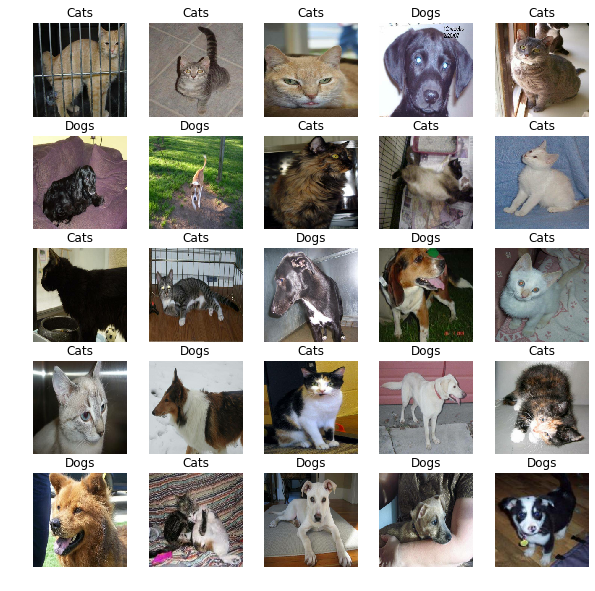

In [54]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(25):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n])
        plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
        plt.axis('off')
show_batch(image_batch.numpy(), label_batch.numpy())
print(label_batch.numpy())
print(len(label_batch.numpy()))

In [0]:
class KerasBatchClassifier(KerasClassifier, BaseEstimator):
    def __init__(self, model, **kwargs):
        super().__init__(model)
        self.fit_kwargs = kwargs
        self._estimator_type = 'classifier'

    def fit(self, *args, **kwargs):
        # taken from keras.wrappers.scikit_learn.KerasClassifier.fit
        self.model = self.build_fn(**self.filter_sk_params(self.build_fn))
        
        
        self.classes_ = np.array([x[1] for x in next(iter(train_ds))])
        print(self.classes_)
        self.__history = self.model.fit_generator(
            self.fit_kwargs.pop('train_generator'), 
            **self.fit_kwargs
        )

In [0]:
# define model
def create_model():
    model = tf.keras.Sequential()
    model.add(Conv2D(32, (3, 3), input_shape=(IMG_HEIGHT, IMG_WIDTH, 3,)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2))
    model.add(Activation('sigmoid'))
    model.compile(optimizer='adam', \
                  loss='binary_crossentropy', \
                  metrics=['accuracy'])
    return model

In [63]:
# https://stackoverflow.com/questions/40854232/keras-scikit-learn-using-fit-generator-with-cross-validation
clf = KerasBatchClassifier(verbose=1, steps_per_epoch=STEPS_PER_EPOCH, epochs=2, train_generator=train_ds, model=create_model)
clf.fit()
# clf = KerasBatchClassifier(model=create_model, verbose=0)
# clf.fit()
# batch_size = [16, 32]
# epochs = [2, 4]
# param_grid = dict(batch_size=batch_size, epochs=epochs)
# grid = GridSearchCV(estimator=clf, param_grid=param_grid, n_jobs=-1, cv=3)
# grid_result = grid.fit(image_batch, label_batch)

[<tf.Tensor: id=73625, shape=(224, 224, 3), dtype=float32, numpy=
array([[[0.10245974, 0.11814602, 0.12206759],
        [0.09034153, 0.10602781, 0.10994938],
        [0.07459757, 0.09028386, 0.09420542],
        ...,
        [0.28720307, 0.19767226, 0.13459453],
        [0.2883331 , 0.19880226, 0.13572451],
        [0.26299897, 0.17346813, 0.11039039]],

       [[0.1188079 , 0.13648997, 0.13941364],
        [0.11497218, 0.13265425, 0.13557792],
        [0.11335853, 0.1310406 , 0.13396427],
        ...,
        [0.29726112, 0.21690398, 0.15223311],
        [0.27926418, 0.19890706, 0.13423619],
        [0.2751397 , 0.19478257, 0.1301117 ]],

       [[0.2968575 , 0.32038692, 0.32038692],
        [0.30107707, 0.32460648, 0.32460648],
        [0.31169468, 0.3352241 , 0.3352241 ],
        ...,
        [0.2631202 , 0.19193673, 0.13145003],
        [0.24459879, 0.17368634, 0.11319964],
        [0.25730035, 0.18778005, 0.12729336]],

       ...,

       [[0.6841822 , 0.6488881 , 0.5900646 ],
  

KeyboardInterrupt: ignored

In [0]:
model.fit_generator(train_ds, steps_per_epoch=STEPS_PER_EPOCH, epochs=2)

In [0]:
def prepare_for_test(ds, cache=True, shuffle_buffer_size=1000):
    # This is a small dataset, only load it once, and keep it in memory.
    # use `.cache(filename)` to cache preprocessing work for datasets that don't
    # fit in memory.
    if cache:
        if isinstance(cache, str):
            ds = ds.cache(cache)
        else:
            ds = ds.cache()
    # ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    # Repeat forever
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    # `prefetch` lets the dataset fetch batches in the background while the model
    # is training.
    # ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return ds

In [0]:
# val_ds = prepare_for_test(val_ds)
validate_ds = val_ds.map(process_path, num_parallel_calls=tf.data.experimental.AUTOTUNE)
predictions = []
anotations = []
for image, label in validate_ds:
    # print("Image shape: ", image.numpy().shape)
    # print("Label: ", label.numpy())
    np_image = np.expand_dims(image.numpy(), axis=0)
    # print(np_image.shape)
    prediction = model.predict(np_image)
    anotation = label.numpy()
    predictions.append(prediction)
    anotations.append(anotation)
    print('Pred: {0}, Anot: {1}'.format(prediction, anotation))

In [0]:
pred_array = tf.argmax(predictions, axis=2).numpy()
# print(pred_array)
anot_array = [0 if x[0] == True else 1 for x in anotations]
print(anot_array)
from sklearn.metrics import accuracy_score, roc_auc_score, recall_score, precision_score, f1_score
print(accuracy_score(anot_array, pred_array))
print(roc_auc_score(anot_array, pred_array))
print(recall_score(anot_array, pred_array))
print(precision_score(anot_array, pred_array))
print(f1_score(anot_array, pred_array))